## Dataset

### Identify domain and topics

- assign domain and topic to the question
- analyze domain and topic distributions

In [ ]:
import sys
sys.path.append("../data/src")
import pandas as pd
from prepare_data import IDENTIFY_DOMAIN_TOPIC_PROMPT, gpt_json_mode,  identify_domain_and_topic

responses = identify_domain_and_topic(datadir="../data/evaluate_llm_factuality_dataset.jsonl", 
                                      savedir = "../data/domain_topic.jsonl")

# incorporate domain and topic fields into dataset examples.
df = pd.read_json("../data/evaluate_llm_factuality_dataset.jsonl", lines=True)
count = 0
for k, row in df.iterrows():
    if row["domain"] != "biograghy":
        try:
            row["domain"] = responses[k]["domain"]
            row["topic"] = responses[k]["topic"]
        except Exception as e:
            print(responses[k])
        count += 1
print(count)
df.to_json("../data/evaluate_llm_factuality_dataset_test.jsonl", lines=True, orient="records", force_ascii=False)

In [3]:
import pandas as pd
df = pd.read_json("../data/evaluate_llm_factuality_dataset.jsonl", lines=True)

d = df.domain.value_counts() 
t = df.topic.value_counts()
print(len(df), len(d), len(t))

6480 483 4740


### Response Length

In [10]:
df = pd.read_json("../data/evaluate_llm_factuality_dataset.jsonl", lines=True)
# print(df.source.unique())

def calculate_text_length(text):
    # Split the text into words
    words = text.strip().split()
    words = [w for w in words if w.strip() != '']
    
    # Count the number of words
    num_words = len(words)
    
    # Return the number of words
    return num_words


for source in ['factcheckgpt', 'factool-qa',  'felm-wk']:
    dfs = df[df['source'] == source]
    for model in ['GPT4_response', 'llama7b_response', 'llama13b_response']:
        responses = dfs[model].to_list()
        L = 0
        for text in responses:
            L += calculate_text_length(text)
        print(source, model, round(L/len(responses), 1))
print("\n")
for model in ['GPT4_response', 'llama7b_response', 'llama13b_response']:
    responses = df[model].to_list()
    L = 0
    for text in responses:
        L += calculate_text_length(text)
    print(model, round(L/len(responses), 1))

factcheckgpt GPT4_response 117.3
factcheckgpt llama7b_response 152.7
factcheckgpt llama13b_response 143.9
factool-qa GPT4_response 39.5
factool-qa llama7b_response 127.3
factool-qa llama13b_response 129.5
felm-wk GPT4_response 62.8
felm-wk llama7b_response 131.0
felm-wk llama13b_response 125.5


GPT4_response 82.2
llama7b_response 132.1
llama13b_response 121.9


## LLM Evaluation

### Evaluate Factuality of Three LLMs

In [ ]:
import sys
sys.path.append("../eval_llm")

import pandas as pd
from evaluate_llm_factuality import get_dataset_model_response, snowballing_evaluation, selfaware_evaluation, fresh_evaluation

df = pd.read_json("../data/evaluate_llm_factuality_dataset.jsonl", lines=True)
models_res = ["llama7b_response", "llama13b_response", "GPT4_response"]

for llm in models_res:
    print(llm)
    llm_responses = get_dataset_model_response(df, 'snowballing', llm)
    results, _, _ = snowballing_evaluation(llm_responses, "../data/llm_eval_results/", llm)
    print([v['accuracy'] for k,v in results.items()])

for llm in models_res:
    print(llm)
    llm_responses = get_dataset_model_response(df, 'selfaware', llm)
    results, labels, preds = selfaware_evaluation(llm_responses, "../data/llm_eval_results/", llm)
    print(results)

for llm in models_res:
    llm_responses = get_dataset_model_response(df, 'freshqa', llm)
    acc = fresh_evaluation(llm_responses, "../data/llm_eval_results/", llm)
    print(llm, acc)

# Run Factool to evaluate free-form llm responses for other four datasets

### Analyze Factool Evaluation Results

In [4]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

# Calculate cost (in USD) for the API calls => 2x API calls per claim
def calcPrice(numClaims, costOpenAI=0.015, costSerper=0.001):
    return numClaims * 2 * (costOpenAI + costSerper)

# Helper function: Sum all elements of an object
def sumAllObj(obj):
    ret = 0
    for k, v in obj.items():
        ret += v
    return ret

# Collect data from project directory
def collect_data(projectdir):
    data = []
    for dirname in os.listdir(projectdir):
        dirpath = os.path.join(projectdir, dirname)
        if os.path.isdir(dirpath):
            if os.path.exists(os.path.join(dirpath, 'eval_result.json')):
                with open(os.path.join(dirpath, 'eval_result.json'), 'r') as f:
                    data.append(json.load(f))
    return data

data = collect_data("../data/llm_eval_results/factool_eval_llm/")

#### Number of False claims

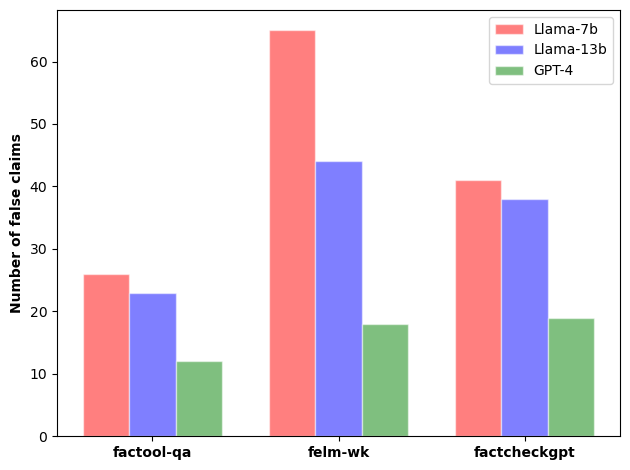

In [6]:
# Filter factool-qa|felm-wk|factcheckgpt datasets and GPT4|llama7b|llama13b llms
falseClaims = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
for d in data:
    if d["llm"] == "GPT4_response":
        if d["dataset"] == "factool-qa":
            falseClaims[0][0] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "felm-wk":
            falseClaims[0][1] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "factcheckgpt":
            falseClaims[0][2] += d["claims"]["numFalseClaims"]
    elif d["llm"] == "llama7b_response":
        if d["dataset"] == "factool-qa":
            falseClaims[1][0] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "felm-wk":
            falseClaims[1][1] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "factcheckgpt":
            falseClaims[1][2] += d["claims"]["numFalseClaims"]
    elif d["llm"] == "llama13b_response":
        if d["dataset"] == "factool-qa":
            falseClaims[2][0] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "felm-wk":
            falseClaims[2][1] += d["claims"]["numFalseClaims"]
        elif d["dataset"] == "factcheckgpt":
            falseClaims[2][2] += d["claims"]["numFalseClaims"]

# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(falseClaims[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, falseClaims[1], color='red', width=barWidth, edgecolor='white', label='Llama-7b', alpha=0.5)
plt.bar(r2, falseClaims[2], color='blue', width=barWidth, edgecolor='white', label='Llama-13b', alpha=0.5)
plt.bar(r3, falseClaims[0], color='green', width=barWidth, edgecolor='white', label='GPT-4', alpha=0.5)
 
# Add xticks on the middle of the group bars
# plt.xlabel('False claims per dataset per LLM', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(falseClaims[0]))], ['factool-qa', 'felm-wk', 'factcheckgpt'], fontweight='bold')
plt.ylabel('Number of false claims', fontweight='bold')
 
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig("../figs/freeform_numfalseclaim.pdf", format='pdf')

#### Percentage of true claims

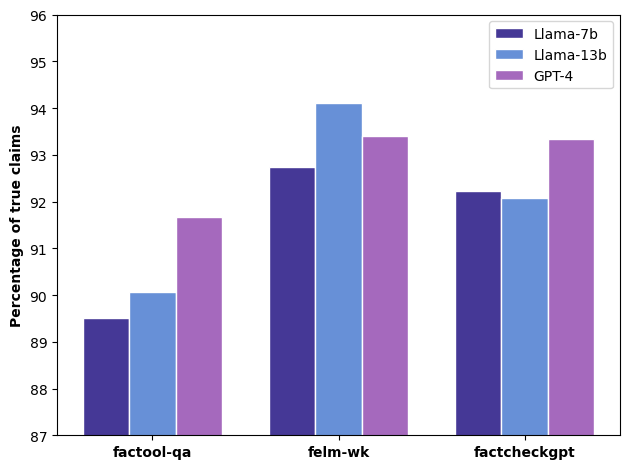

In [11]:
# Filter factool-qa|felm-wk|factcheckgpt datasets and GPT4|llama7b|llama13b llms
def cal_all_claims(d):
    total = d["claims"]["numTrueClaims"] + d["claims"]["numFalseClaims"] + \
    d["claims"]["numUndefinedClaims"] + d["claims"]["numMixedClaims"]
    return total

target = ["numTrueClaims", "numFalseClaims", "numUndefinedClaims", "numMixedClaims"][0]
allClaims = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
targetClaims = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
for d in data:
    if d["llm"] == "GPT4_response":
        if d["dataset"] == "factool-qa":
            allClaims[0][0] += cal_all_claims(d)
            targetClaims[0][0] += d["claims"][target]
        elif d["dataset"] == "felm-wk":
            allClaims[0][1] += cal_all_claims(d)
            targetClaims[0][1] += d["claims"][target]
        elif d["dataset"] == "factcheckgpt":
            allClaims[0][2] += cal_all_claims(d)
            targetClaims[0][2] += d["claims"][target]
    elif d["llm"] == "llama7b_response":
        if d["dataset"] == "factool-qa":
            allClaims[1][0] += cal_all_claims(d)
            targetClaims[1][0] += d["claims"][target]
        elif d["dataset"] == "felm-wk":
            allClaims[1][1] += cal_all_claims(d)
            targetClaims[1][1] += d["claims"][target]
        elif d["dataset"] == "factcheckgpt":
            allClaims[1][2] += cal_all_claims(d)
            targetClaims[1][2] += d["claims"][target]
    elif d["llm"] == "llama13b_response":
        if d["dataset"] == "factool-qa":
            allClaims[2][0] += cal_all_claims(d)
            targetClaims[2][0] += d["claims"][target]
        elif d["dataset"] == "felm-wk":
            allClaims[2][1] += cal_all_claims(d)
            targetClaims[2][1] += d["claims"][target]
        elif d["dataset"] == "factcheckgpt":
            allClaims[2][2] += cal_all_claims(d)
            targetClaims[2][2] += d["claims"][target]

target_ratio = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
for i in range(3):
    for j in range(3):
        target_ratio[i][j] = round(targetClaims[i][j]/allClaims[i][j], 4) * 100

# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(target_ratio[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, target_ratio[1], color='#453896', width=barWidth, edgecolor='white', label='Llama-7b')
plt.bar(r2, target_ratio[2], color='#6790D7', width=barWidth, edgecolor='white', label='Llama-13b')
plt.bar(r3, target_ratio[0], color='#A569BD', width=barWidth, edgecolor='white', label='GPT-4')
 
# Add xticks on the middle of the group bars
# plt.xlabel('True claims per dataset per LLM', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(target_ratio[0]))], ['factool-qa', 'felm-wk', 'factcheckgpt'], fontweight='bold')
plt.ylabel('Percentage of true claims', fontweight='bold')
plt.ylim(87, 96)
 
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig("../figs/freeform_ratiotrueclaim.pdf", format='pdf')

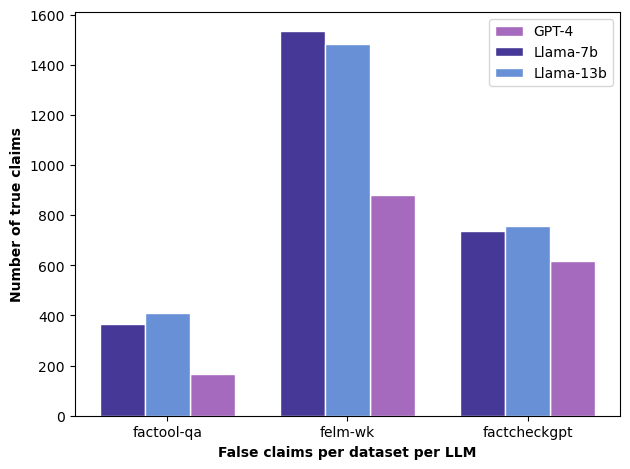

In [12]:
# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(targetClaims[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r3, targetClaims[0], color='#A569BD', width=barWidth, edgecolor='white', label='GPT-4')
plt.bar(r1, targetClaims[1], color='#453896', width=barWidth, edgecolor='white', label='Llama-7b')
plt.bar(r2, targetClaims[2], color='#6790D7', width=barWidth, edgecolor='white', label='Llama-13b')
 
# Add xticks on the middle of the group bars
plt.xlabel('False claims per dataset per LLM', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(targetClaims[0]))], ['factool-qa', 'felm-wk', 'factcheckgpt'])
plt.ylabel('Number of true claims', fontweight='bold')
 
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig("../figs/freeform_numtrueclaim.pdf", format='pdf')

#### All claims

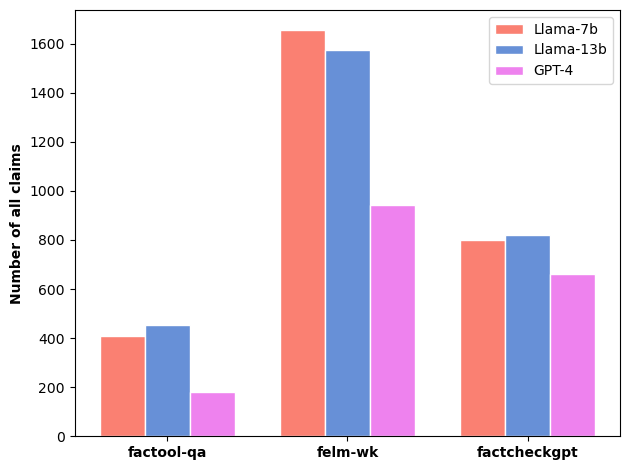

In [14]:
# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(allClaims[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot
plt.bar(r1, allClaims[1], color='salmon', width=barWidth, edgecolor='white', label='Llama-7b')
plt.bar(r2, allClaims[2], color='#6790D7', width=barWidth, edgecolor='white', label='Llama-13b')
plt.bar(r3, allClaims[0], color='violet', width=barWidth, edgecolor='white', label='GPT-4')
 
# Add xticks on the middle of the group bars
# plt.xlabel('False claims per dataset per LLM', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(allClaims[0]))], ['factool-qa', 'felm-wk', 'factcheckgpt'], fontweight='bold')
plt.ylabel('Number of all claims', fontweight='bold')
 
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig("../figs/freeform_allclaim.pdf", format='pdf')

#### USD Cost

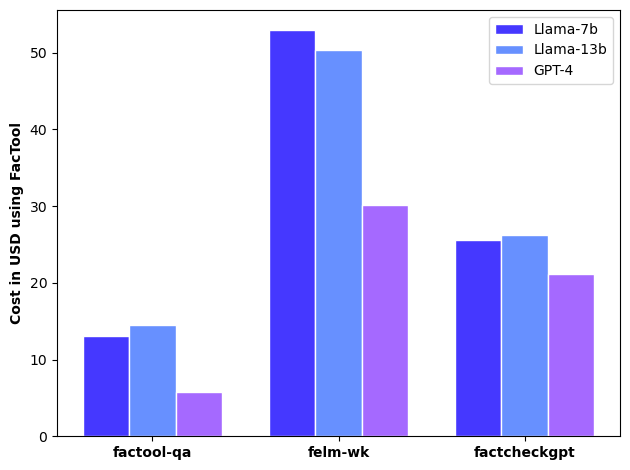

In [15]:
# Filter factool-qa|felm-wk|factcheckgpt datasets and GPT4|llama7b|llama13b llms
costs = [[0, 0, 0],[0, 0, 0],[0, 0, 0]]
for d in data:
    if d["llm"] == "GPT4_response":
        if d["dataset"] == "factool-qa":
            costs[0][0] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "felm-wk":
            costs[0][1] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "factcheckgpt":
            costs[0][2] += calcPrice(sumAllObj(d["claims"]))
    elif d["llm"] == "llama7b_response":
        if d["dataset"] == "factool-qa":
            costs[1][0] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "felm-wk":
            costs[1][1] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "factcheckgpt":
            costs[1][2] += calcPrice(sumAllObj(d["claims"]))
    elif d["llm"] == "llama13b_response":
        if d["dataset"] == "factool-qa":
            costs[2][0] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "felm-wk":
            costs[2][1] += calcPrice(sumAllObj(d["claims"]))
        elif d["dataset"] == "factcheckgpt":
            costs[2][2] += calcPrice(sumAllObj(d["claims"]))

# set width of bars
barWidth = 0.25
 
# Set position of bar on X axis
r1 = np.arange(len(costs[0]))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
 
# Make the plot

plt.bar(r1, costs[1], color='#4538FF', width=barWidth, edgecolor='white', label='Llama-7b')
plt.bar(r2, costs[2], color='#6790FF', width=barWidth, edgecolor='white', label='Llama-13b')
plt.bar(r3, costs[0], color='#A569FF', width=barWidth, edgecolor='white', label='GPT-4')
 
# Add xticks on the middle of the group bars
# plt.xlabel('Costs per dataset per LLM', fontweight='bold')
plt.xticks([r + barWidth for r in range(len(costs[0]))], ['factool-qa', 'felm-wk', 'factcheckgpt'], fontweight='bold')
plt.ylabel('Cost in USD using FacTool', fontweight='bold')
 
# Create legend & Show graphic
plt.legend()
# plt.show()
plt.tight_layout()
plt.savefig("../figs/freeform_cost.pdf", format='pdf')

## Fact-checking system Evaluation

### Perplexity AI

In [ ]:
import sys
sys.path.append("../exp/")
from pplx import call_pplxai

df = pd.read_json("../data/Factbench.jsonl", lines=True)
data = []
for source in ['factool-qa', 'felm-wk']:        
    t = df[df['source'] == source]
    print(len(t))
    for k, v in t.iterrows():
        for claim in v['claims']:
            prompt = f"Is the following claim true or false: {claim}"
            r = call_pplxai(prompt)
            data.append({"source": source, "id":k, "claim": claim, "pplxai_response": r})
            pd.DataFrame(data).to_json("../exp/checker_eval_results/pplxai_evaluation.jsonl", 
                                       lines=True, orient="records")        

#### Parse Responses

In [ ]:
import string
import pandas as pd
df = pd.read_json("../exp/checker_eval_results/pplxai_evaluation.jsonl", lines=True)
print(len(df), df.columns)

decisions = []
unknown = []
outputs = []
for i, output in enumerate(df['pplxai_response'].to_list()):
    generated_answer = output.strip().lower()
    if "true" in generated_answer or "false" in generated_answer:
        outputs.append(output)
        if "true" in generated_answer and "false" not in generated_answer:
            is_supported = True
        elif "false" in generated_answer and "true" not in generated_answer:
            is_supported = False
        else:
            is_supported = generated_answer.index("true") > generated_answer.index("false")
    else:
        if output == "":
            is_supported = "unknown"
            # print(df['claim'].to_list()[i])
            claim = df['claim'].to_list()[i]
            prompt = f"Is the following claim true or false: {claim}"
            r = call_pplxai(prompt)
            print(r)
            unknown.append(r)
            outputs.append(r)
        else:
            is_supported = all([keyword not in generated_answer.lower().translate(str.maketrans("", "", string.punctuation)).split() for keyword in ["not", "cannot", "unknown", "information"]])
            outputs.append(output)
    decisions.append(is_supported)
print(len(outputs))

# df['pplxai_response'] = outputs
df["is_supported"] = decisions
df.to_json("../exp/checker_eval_results/pplxai_evaluation.jsonl", lines=True, orient="records") 

#### Evaluate Results

In [ ]:
from eval import eval_binary_classification, eval_classification

df = pd.read_json("../data/Factbench.jsonl", lines=True)
gold_labels = {'factcheckgpt': [], 'factool-qa': [], 'felm-wk': [], 'halueval-dolly15k': []}
for source in ['factcheckgpt', 'factool-qa', 'felm-wk', 'halueval-dolly15k']:        
    t = df[df['source'] == source]
    if source == 'halueval-dolly15k':
        gold_labels[source] = list(t['response_label'])
    else:
        for l in t['claim_labels']:
            gold_labels[source] += l

df = pd.read_json("../exp/checker_eval_results/pplxai_evaluation.jsonl", lines=True)
for source in ['factool-qa', 'felm-wk']:    
    d1 = df[df['source'] == source]
    # print(len(d1))
    p = d1["is_supported"]
    v = gold_labels[source]
    mt = eval_binary_classification(v, p, pos_label=True)
    mf = eval_binary_classification(v, p, pos_label=False)
    print(f"{mt['precision']} & {mt['recall']} & {mt['F1']} & {mf['precision']} & {mf['recall']} & {mf['F1']}")

### FactCheckGPT by langchain

In [ ]:
import pandas as pd
from factcheck_langchain import run_langchain
df = pd.read_json("../data/Factbench.jsonl", lines=True)
claims, gold_labels = [], []
for source in ['factool-qa', 'felm-wk']:
    t = df[df['source'] == source]
    for l in t['claim_labels']:
        gold_labels += l
    for c in t['claims']:
        claims += c
print(len(claims), len(gold_labels))

outputs = []
for claim in claims:
    output = run_langchain(claim)
    outputs.append(output)
    pd.DataFrame(outputs).to_json("../exp/checker_eval_results/langchain_results.jsonl", lines=True, orient="records")

#### Evaluate

In [22]:
from collections import Counter
f = pd.read_json("../exp/checker_eval_results/langchain_results.jsonl", lines=True)
print(len(f), f.columns)
res = f["langchain_output"].to_list()
# Counter(res)

for source in ['factool-qa', 'felm-wk']:
    if source == "factool-qa":
        g, p = [], []
        for i in range(233):
            if res[i] in ["True", "False"]:
                g += [gold_labels[i]]
                p += [res[i] == "True"]
    elif source == "felm-wk":
        g, p = [], []
        for i in range(233, 765):
            if res[i] in ["True", "False"]:
                g += [gold_labels[i]]
                p += [res[i] == "True"]
    print(len(g))    
    mt = eval_binary_classification(g, p, pos_label=True)
    mf = eval_binary_classification(g, p, pos_label=False)
    print(f"{mt['precision']} & {mt['recall']} & {mt['F1']} & {mf['precision']} & {mf['recall']} & {mf['F1']}")

765 Index(['claim', 'langchain_output', 'langchain_messages', 'usd-cost',
       'time-cost', 'loop_count'],
      dtype='object')
195
0.88 & 0.88 & 0.88 & 0.63 & 0.63 & 0.63
391
0.81 & 0.87 & 0.84 & 0.55 & 0.44 & 0.49


### FacTool

run factool_chatgpt.py

#### Evaluate factool-chatgpt results

In [26]:
df = pd.read_json("../exp/checker_eval_results/factool_chatgpt_results.jsonl", lines=True)
print(len(df), df.columns)  # 50+184
for source in ['factool-qa', 'felm-wk']:
    t = df[df['source'] == source]
    # print(len(t))
    claims_info = t['claims_info'].to_list()
    claims, gold_labels, pred_labels, evidences = get_claim_info(claims_info)
    pred_labels = [True if p==1 else False for p in pred_labels]
    mt = eval_binary_classification(gold_labels, pred_labels, pos_label=True)
    mf = eval_binary_classification(gold_labels, pred_labels, pos_label=False)
    print(f"{mt['precision']} & {mt['recall']} & {mt['F1']} & {mf['precision']} & {mf['recall']} & {mf['F1']}")

234 Index(['claims_info', 'source', 'prompt', 'response', 'start', 'end'], dtype='object')
233 233 233 233
0.92 & 0.59 & 0.72 & 0.39 & 0.84 & 0.53
532 532 532 532
0.78 & 0.62 & 0.69 & 0.35 & 0.54 & 0.43


#### Based on Factool Evidence, verify by LLaMA3

In [28]:
from factool_llama3_verify import verifier_prompt, LLaMA3

def get_claim_info(claims_info):
    claims, gold_labels, pred_labels, evidences = [], [], [], []
    for id, response in enumerate(claims_info):
        # if gold_num_claims[id] != len(response):
        #     print(id, len(response), gold_num_claims[id])
        #     break
        for k, claim in response.items():
            # k is the claim text, v information of the claim
            claims.append(claim['claim'])
            gold_labels.append(claim['prior_label'])
            pred_labels.append(claim['label'])
            evidences.append([evid['web_page_snippet_manual'] for evid in claim['evidence_list']])
    print(len(claims), len(gold_labels), len(pred_labels), len(evidences))
    return claims, gold_labels, pred_labels, evidences

def get_model_inputs(claims, evidences, prompt=verifier_prompt):
    samples = []
    for claim, evids in zip(claims, evidences):
        evidence = "\n"
        for i, evid in enumerate(evids):
            evidence += f"evidence_{i}: {evid} \n"
        samples.append(prompt.format(claim=claim, evidence=evidence))
    print(len(samples))
    return samples

In [ ]:
import pandas as pd
df = pd.read_json("../exp/checker_eval_results/factool_chatgpt_results.jsonl", lines=True)

print(len(df), df.columns)  # 50+184
samples = []
for source in ['factool-qa', 'felm-wk']:
    t = df[df['source'] == source]
    # print(len(t))
    claims_info = t['claims_info'].to_list()
    claims, gold_labels, pred_labels, evidences = get_claim_info(claims_info)
    samples += get_model_inputs(claims, evidences, prompt=verifier_prompt)
print(len(samples))
# print(samples[0])

model = LLaMA3()
responses = []
batch_size = 20
for i in range(int(len(samples)/batch_size)+1):
    inputs = samples[i*batch_size:(i+1)*batch_size]
    outputs = model.generate(inputs)
    responses += outputs
    pd.DataFrame(responses).to_json("../exp/checker_eval_results/factool_evidence_llama3_verifier_responses.jsonl", 
                                    lines=True, orient="records")
print(len(responses))

#### Parse Responses and Evaluate

In [ ]:
import re
decisions = []
count = 0
for i, text in enumerate(responses):
    match = re.findall(r'"factuality": (true|false)', text.lower())
    if match:
        is_supported = match[0]
    else:
        count += 1
        is_supported = 'false'
        # print("No match found.")
    decisions.append(is_supported)
decisions = [True if d == 'true' else False for d in decisions]
print(count, len(decisions))

predictions = {'factool-qa': decisions[:233], 'felm-wk': decisions[233:]}
df = pd.read_json("../exp/checker_eval_results/factool_chatgpt_results.jsonl", lines=True)
print(len(df), df.columns)  # 50+184
for source in ['factool-qa', 'felm-wk']:
    t = df[df['source'] == source]
    # print(len(t))
    claims_info = t['claims_info'].to_list()
    claims, gold_labels, _, evidences = get_claim_info(claims_info)
    pred_labels = predictions[source]
    mt = eval_binary_classification(gold_labels, pred_labels, pos_label=True)
    mf = eval_binary_classification(gold_labels, pred_labels, pos_label=False)
    print(f"{mt['precision']} & {mt['recall']} & {mt['F1']} & {mf['precision']} & {mf['recall']} & {mf['F1']}")

### FActScore